### Ticker Technical Analysis 
Uses ticker pricing data for given date range and analyzes the buy and sell signals. 

In [47]:
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
from datetime import datetime, timedelta

In [48]:
# get tomorrows date so we can use this in the yf.download as an end date

date = datetime.now() + timedelta(days=1)
fmt_date = date.strftime('%Y-%m-%d')
fmt_date

'2024-10-14'

In [49]:
# enter ticker symbol and date range to retrieve

ticker = 'sofi'
start_date = '2024-01-25'
end_date =  fmt_date

In [50]:
# Fetch data for a ticker via yahoo api 

df_intra = yf.download(ticker, start_date, end_date, interval='60m', progress=False)
df = yf.download(ticker, start_date, end_date, progress=False)

In [51]:
# EMA - Calculates the Daily EMA, Intra-Day EMA & stores it to respective dataframes

def calculate_ema(fast_ema, slow_ema, data_set):
    fema = data_set['Close'].ewm(span=fast_ema, adjust=False).mean()
    sema = data_set['Close'].ewm(span=slow_ema, adjust=False).mean()
    return fema, sema

# call calculate_ema and pass in the ema values and data sets
df['EMA_A'], df['EMA_B'] = calculate_ema(5, 7, df)
df_intra['EMA_A'], df_intra['EMA_B'] = calculate_ema(5, 7, df_intra)


In [52]:
# RSI - Calulates the RSI and adds median_rsi and RSI to respective dataframes

def calculate_rsi(dataset, overbought_level, oversold_level):
    delta = dataset['Close'].diff(1)

    # Calculate the exponentially weighted moving averages of gains and losses
    gain_ewm = delta.where(delta > 0, 0).ewm(span=14, adjust=False).mean()
    loss_ewm = -delta.where(delta < 0, 0).ewm(span=14, adjust=False).mean()

    # Calculate the relative strength (RS)
    rs = gain_ewm / loss_ewm

    # Calculate the RSI
    rsi = 100 - (100 / (1 + rs))

    # Compute the median between overbought and oversold levels
    median_rsi = np.median([overbought_level, oversold_level])

    dataset['Median_RSI'] = np.where(rsi > median_rsi, 'above_median', 'below_median')

    dataset['rsi'] = rsi

    return rs, rsi, median_rsi


my_rsi_values = calculate_rsi(df, 10, 90)
my_irsi_values = calculate_rsi(df_intra, 10, 90)

In [53]:
df_intra.tail(5)

,Open,High,Low,Close,Adj Close,Volume,EMA_A,EMA_B,Median_RSI,rsi
Datetime,,,,,,,,,,
2024-10-11 11:30:00,8.8950,8.960,8.8800,8.940,8.940,4978223,8.816731,8.780781,above_median,75.641678
2024-10-11 12:30:00,8.9399,8.950,8.8900,8.940,8.940,3120139,8.857820,8.820585,above_median,75.641678
2024-10-11 13:30:00,8.9400,8.990,8.9200,8.990,8.990,3986151,8.901880,8.862939,above_median,78.265981
2024-10-11 14:30:00,8.9899,9.070,8.9836,9.015,9.015,7879761,8.939587,8.900954,above_median,79.537855
2024-10-11 15:30:00,9.0160,9.035,8.9900,9.010,9.010,6398177,8.963058,8.928216,above_median,78.478040


In [54]:
# Calculate MACD and signal line
def calculate_macd(df):
    exp1 = df['Close'].ewm(span=12, adjust=False).mean()
    exp2 = df['Close'].ewm(span=26, adjust=False).mean()
    macd = exp1 - exp2
    signal = macd.ewm(span=9, adjust=False).mean()
    return macd, signal

df['MACD'], df['Signal'] = calculate_macd(df)
df_intra['MACD'], df_intra['Signal'] = calculate_macd(df_intra)

In [55]:
# # debug code

# closing_prices = df[['Close', 'MACD', 'Signal']]
# closing_prices.tail(60)

In [56]:
# Calculate Signal

def signal(data_set):
    rsi_check = data_set['Median_RSI'] == 'above_median'
    crossed_above_with_rsi = (data_set['EMA_A'] > data_set['EMA_B']) & (data_set['EMA_A'].shift(1) < data_set['EMA_B'].shift(1)) & (rsi_check)
    crossed_above = (data_set['EMA_A'] > data_set['EMA_B']) & (data_set['EMA_A'].shift(1) < data_set['EMA_B'].shift(1)) 
    crossed_above_macd = (data_set['MACD'] > data_set['Signal']) & (data_set['MACD'].shift(1) <= data_set['Signal'].shift(1))
    return crossed_above_with_rsi, crossed_above, crossed_above_macd

# Capture the output of the signal function
crossed_above_with_rsi, crossed_above, crossed_above_macd = signal(df)
icrossed_above_with_rsi, icrossed_above, icrossed_above_macd = signal(df_intra)

### Result of the Signal function: 
will be added to dataframe & also the condition for crossed down.

In [57]:
def algo_result(dataset, indctr1, indctr2, indctr3):
    # DAILY - This uses the result of the choice of indctrs.  
    dataset.loc[indctr1, 'Cross_Direction'] = 'crossed up'

    # Identify when the A-day EMA crosses below the B-Day EMA
    crossed_below = (dataset['EMA_A'] < dataset['EMA_B']) & (dataset['EMA_A'].shift(1) > dataset['EMA_B'].shift(1))
    dataset.loc[crossed_below, 'Cross_Direction'] = 'crossed down'

    # Filter for rows where the 5-day EMA crossed either above or below the 21-day EMA
    condition_met = dataset[dataset['Cross_Direction'].notna()]

    return condition_met

In [58]:
# INTER DAY - pass in the arguments for condition_met
condition_met = algo_result(df, crossed_above_with_rsi, crossed_above, crossed_above_macd)

# Display the dates when the conditions were met and the direction of the crossover
print("\nDates when the conditions were met and cross direction:")
condition_met[['Close', 'EMA_A', 'EMA_B', 'Cross_Direction', 'Median_RSI', 'rsi']]


Dates when the conditions were met and cross direction:


,Close,EMA_A,EMA_B,Cross_Direction,Median_RSI,rsi
Date,,,,,,
2024-01-29,9.160,8.146667,8.021875,crossed up,above_median,98.339708
2024-02-02,7.880,7.943292,7.944578,crossed down,below_median,49.868295
2024-02-08,8.080,7.868798,7.866292,crossed up,above_median,56.463604
2024-02-23,8.170,8.221682,8.224202,crossed down,above_median,50.172197
2024-02-26,8.540,8.327788,8.303152,crossed up,above_median,61.487455
2024-03-05,7.270,8.264895,8.359035,crossed down,below_median,27.845026
2024-03-26,7.200,7.293001,7.301939,crossed down,below_median,41.450641
2024-04-03,7.540,7.348955,7.335206,crossed up,above_median,57.420132
2024-04-15,7.120,7.386787,7.418127,crossed down,below_median,37.915286


In [59]:
# INTRA DAY - pass in the arguments for condition_met
icondition_met = algo_result(df_intra, icrossed_above_with_rsi, icrossed_above, icrossed_above_macd)

# Display the dates when the conditions were met and the direction of the crossover
print("\nDates when the conditions were met and cross direction:")
icondition_met[['Close', 'EMA_A', 'EMA_B', 'Cross_Direction', 'Median_RSI', 'rsi']]


Dates when the conditions were met and cross direction:


,Close,EMA_A,EMA_B,Cross_Direction,Median_RSI,rsi
Datetime,,,,,,
2024-01-25 11:30:00,7.6000,7.660000,7.662812,crossed down,below_median,31.707283
2024-01-29 09:30:00,9.2650,8.162071,8.027274,crossed up,above_median,95.726802
2024-01-30 12:30:00,8.6350,8.803622,8.811685,crossed down,below_median,48.692707
2024-02-05 09:30:00,7.5200,7.746842,7.766040,crossed down,below_median,26.215835
2024-02-06 09:30:00,7.8100,7.665645,7.660197,crossed up,above_median,60.446709
...,...,...,...,...,...,...
2024-09-26 15:30:00,7.7700,7.758541,7.757185,crossed up,above_median,50.234079
2024-09-30 13:30:00,7.8450,7.915566,7.918942,crossed down,below_median,40.061669
2024-10-02 13:30:00,7.7800,7.738026,7.736046,crossed up,above_median,53.183278


### Plot 'crossed up' and 'crossed down' signals on line graph, and calculate total return


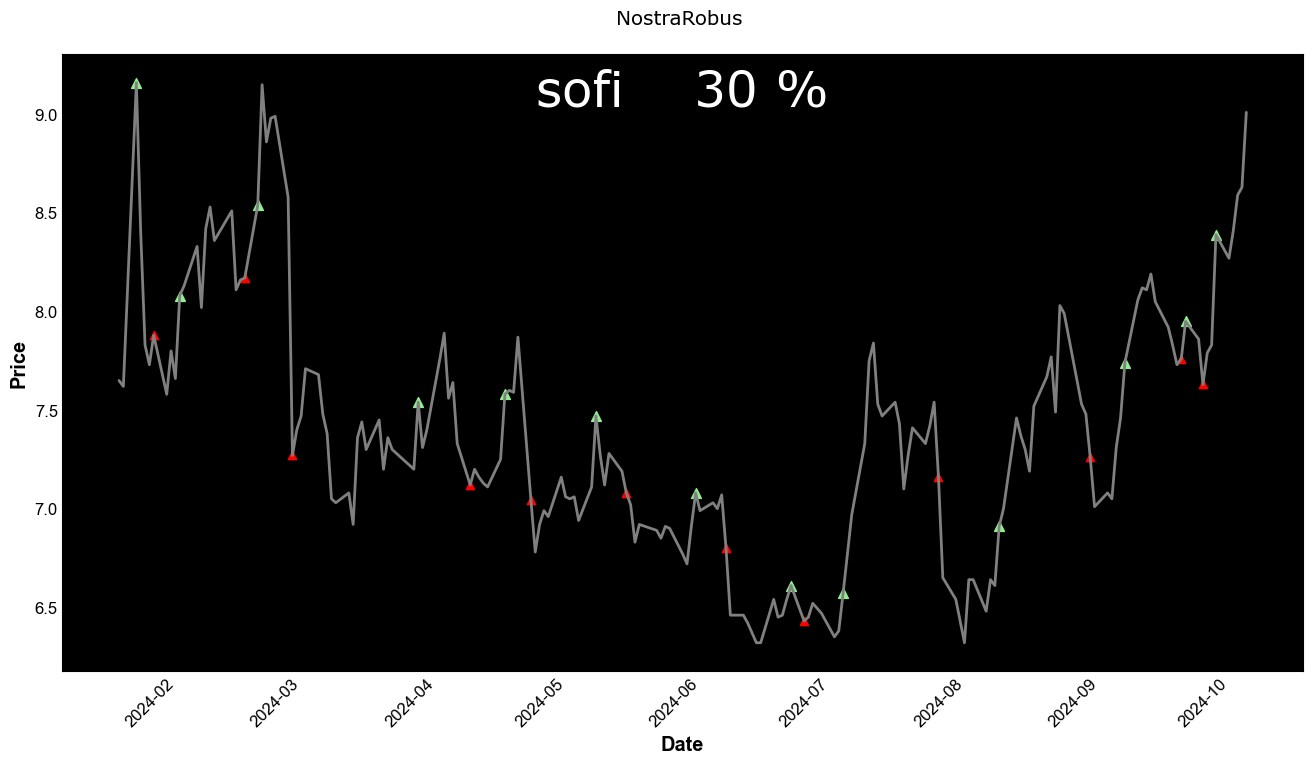

Results For Ticker:   sofi
Initial Investment:  9.15999984741211
Final Portfolio Value:  11
Profit/Loss:  2.7
Percent: 29.5%




,Action,Date,Open,Close,Price,Cash
0,Buy,2024-01-29,8.82,9.160,9.16,0.000000
1,Sell,2024-02-02,7.58,7.880,7.58,7.880000
2,Buy,2024-02-08,7.70,8.080,8.08,-0.200000
3,Sell,2024-02-23,8.17,8.170,8.17,7.970000
4,Buy,2024-02-26,8.19,8.540,8.54,-0.570000
5,Sell,2024-03-05,8.07,7.270,8.07,6.700000
6,Buy,2024-04-03,7.31,7.540,7.54,-0.840000
7,Sell,2024-04-15,7.33,7.120,7.33,6.280000
8,Buy,2024-04-23,7.24,7.580,7.58,-1.300000
9,Sell,2024-04-29,7.37,7.045,7.37,5.745000


In [60]:
# Initialize variables
init_cost = 1 # we need this set so when conditions are not met, we don't divide by 0
cash = init_cost  # Initial cash balance
shares_owned = 0
portfolio_value = cash
prev_crossed_above = False
rsi_above_median = False
transactions = []
last_trans = '' # not being used
df.iloc[-1, df.columns.get_loc('Cross_Direction')] = last_trans # not being used

# Plot the line graph with arrows indicating the direction of crossover
plt.figure(figsize=(16, 8))
plt.plot(df.index, df['Close'], label='Close Price', color='gray')
plt.gca().set_facecolor('black')  # Set the background color to black
plt.xticks(rotation=45)




# Find the first crossed up event and set the initial cost
for index, row in df.iterrows():
    if row['Cross_Direction'] == 'crossed up':
        init_cost = row['Close']  # Set init_cost to the price at the first crossed up event
        cash = init_cost  # Set cash to the initial cost
        break

# Loop through the dataframe
for index, row in df.iterrows():
    if row['Cross_Direction'] == 'crossed up' and prev_crossed_above == False:  # Check if the Cross_Direction column is 'crossed up'
        # Buy one share
        # shares_owned += 1
        cash -= row['Close']  # Deduct purchase price from cash
        transactions.append(('Buy', index, row['Open'], row['Close'], row['Close'], cash))
        prev_crossed_above = True
        plt.scatter(index, row['Close'], marker='^', color='lightgreen', s=50, label='Crossed Up')
    elif row['Cross_Direction'] == 'crossed down' and prev_crossed_above:  # Check if the Cross_Direction column is 'crossed down':
        cash += row['Close'] #* shares_owned  # Add sale price to cash
        transactions.append(('Sell', index, row['Open'], row['Close'], row['Open'], cash))
        prev_crossed_above = False
        plt.scatter(index, row['Close'], marker='^', color='red', label='Crossed Down')
    else:
        pass
    
# Calculate final portfolio value
last_close_price = df['Close'].iloc[-1] #get last close price in order to calc our return
portfolio_value =  last_close_price - cash  #portfolio value is our initial purchase price minus last close price.
initial_investment = init_cost # Initial cash investment
profit_loss = portfolio_value - initial_investment # net difference of our investment and final close price
percent = (profit_loss / initial_investment) * 100 # profit_loss as percent of investment

# Add the ticker symbol and other things as labels
plt.text(0.5, 0.9, ticker + '    ' + str(round(percent)) + ' %', transform=plt.gca().transAxes, fontsize=36, verticalalignment='bottom', \
         horizontalalignment='center', fontname='MS Reference Sans Serif', fontweight='bold', color='white')
plt.title('NostraRobus \n', fontname='MS Reference Sans Serif', fontweight='bold', color='black')
plt.xlabel('Date', color='black')
plt.ylabel('Price', color='black')
plt.tick_params(axis='x', colors='black')
plt.tick_params(axis='y', colors='black')
plt.grid(False)
plt.show()



print('Results For Ticker:  ', ticker)
print('Initial Investment: ', initial_investment)
print("Final Portfolio Value: ", int(portfolio_value))
print("Profit/Loss: ", round(profit_loss,1))
print("Percent: {:.1f}%".format(percent))
print('\n')
transactions_df = pd.DataFrame(transactions, columns=['Action', 'Date', 'Open', 'Close', 'Price', 'Cash'])
transactions_df



### Same calculation as line graph but with candlestick graph

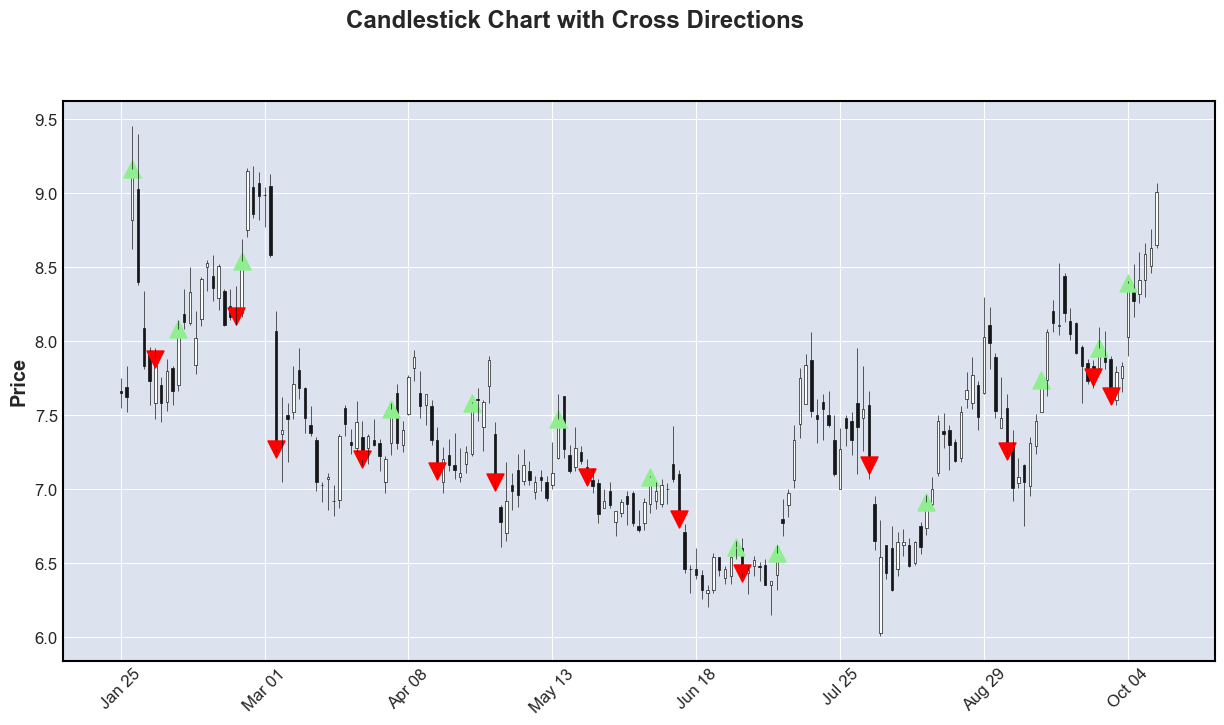

In [61]:
# Plot the candlestick chart with the custom black background
mpf.plot(
    df,
    type='candle',
    title='Candlestick Chart with Cross Directions',
    figsize=(16, 8),
    ylabel='Price',
    addplot=[
        mpf.make_addplot(
            np.where(df['Cross_Direction'] == 'crossed up', df['Close'], np.nan),
            type='scatter',
            markersize=150,  # Marker size
            marker='^',      # Upward triangle for 'crossed up'
            color='lightgreen'  # Color for 'crossed up'
        ),
        mpf.make_addplot(
            np.where(df['Cross_Direction'] == 'crossed down', df['Close'], np.nan),
            type='scatter',
            markersize=150,  # Marker size
            marker='v',      # Downward triangle for 'crossed down'
            color='red'      # Color for 'crossed down'
        )
    ]
)


### Intraday Candlestick Graph

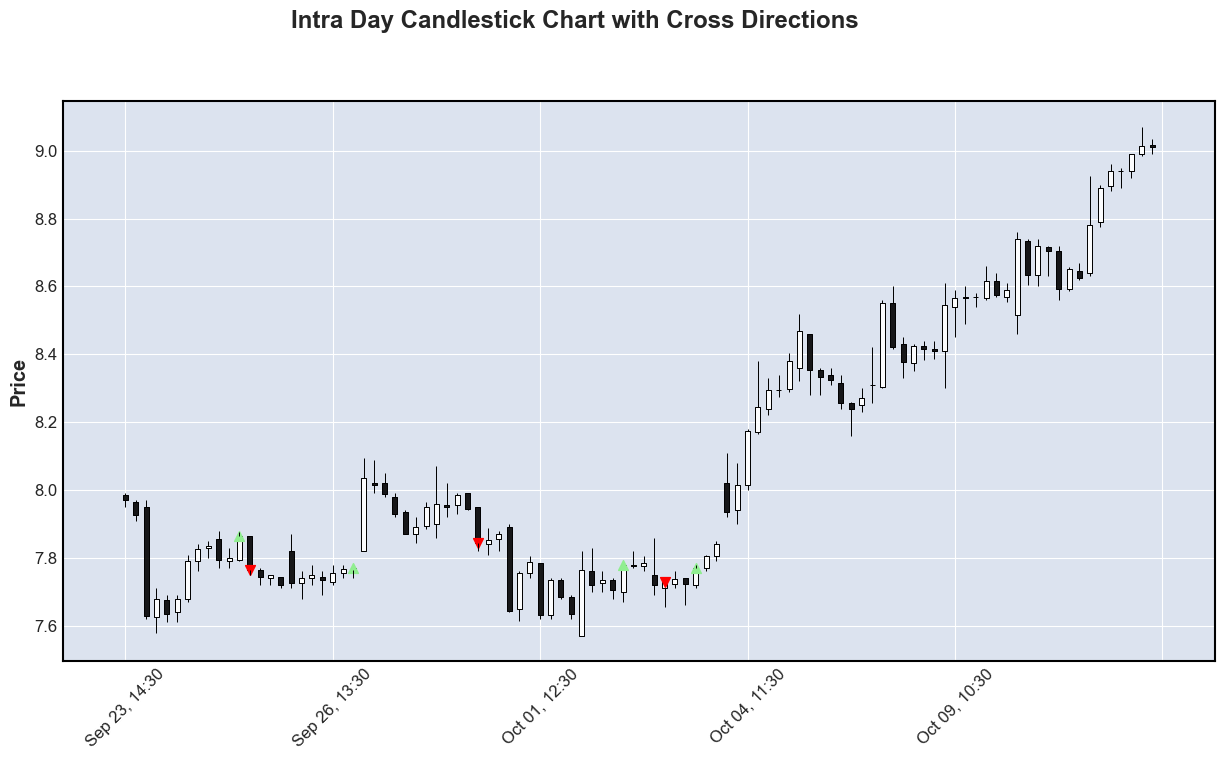

In [68]:
# Use lat 30 days for intraday graph 
start_span = '2024-09-25'
end_span = '2024-09-30'
date_range = df_intra[start_span:end_span]

span = 20
span_days = pd.Timestamp.now() - pd.Timedelta(days=span)
df_intra_span = df_intra[df_intra.index >= span_days]

span = df_intra_span # use date_range or df_intra_span 

# Plot the INTRA DAY candlestick & SIGNAL chart with the custom black background
mpf.plot(
    span,
    type='candle',
    title='Intra Day Candlestick Chart with Cross Directions',
    figsize=(16, 8),
    ylabel='Price',
    warn_too_much_data=len(df_intra_span) + 1,
    addplot=[
        mpf.make_addplot(
            np.where(span['Cross_Direction'] == 'crossed up', span['Close'], np.nan),
            type='scatter',
            marker='^',      # Upward triangle for 'crossed up'
            markersize=50,  # Marker size
            color='lightgreen'  # Color for 'crossed up'
        ),
        mpf.make_addplot(
            np.where(span['Cross_Direction'] == 'crossed down', span['Close'], np.nan),
            type='scatter',
            marker='v',      # Downward triangle for 'crossed down'
            markersize=50,  # Marker size
            color='red'      # Color for 'crossed down'
        )
    ]
)